# Sentinel Hub Processing API requests

In this example notebook we will show how to use the `SentinelHubRequest` to download satellite imagery from the Sentinel Hub's [Processing API](https://docs.sentinel-hub.com/api/latest/#/API/).

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from utils import BBoxSelector

from sentinelhub import SentinelHubRequest, SentinelHubDownloadClient, DataSource, \
    MimeType, DownloadRequest, CRS, BBox

## Credentials

In the [Sentinel Hub dashboard](https://apps.sentinel-hub.com/dashboard/) under "User settings" there is the "OAuth clients" where we create a new OAuth client and use its CLIENT_ID and CLIENT_SECRET to create an instance of `sentinelhub.SHConfig`. We provide the INSTANCE_ID we already have.

If we don't provide any credentials, sentinelhub-py will try to read our credentials from the system.

In [2]:
from sentinelhub import SHConfig

# In case you put the credentials into the configuration file you can leave this unchanged
CLIENT_ID = ''
CLIENT_SECRET = ''

if CLIENT_ID and CLIENT_SECRET:
    config = SHConfig()
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
else:
    config = None

## Pick the area of interest

For picking the area of interest (AOI) we use `utils.BBoxSelector`. For it to work, the `ipyleaflet` jupyter plug-in has to be installed ([docs](https://ipyleaflet.readthedocs.io/en/latest/), [github](https://github.com/jupyter-widgets/ipyleaflet)).

Once the AOI is chosen, we use `selector.bbox` and `selector.size` as parameters to build the request.

In [3]:
selector = BBoxSelector(BBox(bbox=[46.16, -16.15, 46.51, -15.58], crs=CRS.WGS84), zoom=9, resolution=100)
selector.show()

Map(center=[-15.864999999999998, 46.334999999999994], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Downloading a single TIFF image

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/reference/), using the `SentinelHubRequest` class. Each Processing API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/#/Evalscript/V3/README).

### Build the request

In [4]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"],
                units: "REFLECTANCE"
            }],
            output: {
                bands: 3,
                sampleType: "FLOAT32"
            }
        };
    }

    function evaluatePixel(sample) {
        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
"""

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L1C,
            time_interval=('2017-06-01T07:12:03', '2017-06-15T07:12:04'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=selector.bbox,
    size=selector.size,
    config=config
)

### Execute the request

In [5]:
img = request.get_data()[0]

### Visualize the downloaded image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


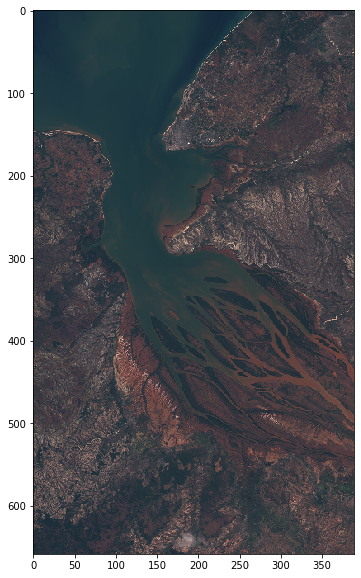

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(img, vmin=0, vmax=1);

## Downloading multiple responses as a TAR archive

Processing API enables us to also download multiple files in one response, packed together in a TAR archive.

### Build the request

We will get the same image as in the previous request, but we will download digital numbers (DN) instead of REFLECTANCE as we did before. We will download values as UINT16 in a TIFF file and the normalization factor value in a JSON file. After the download we will be able to get the same FLOAT32 values as we did in the previous request by multiplying 16 bit values with the normalization factor. This is more efficient, since we download half as much data, but we don't use any precision.

In [7]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"],
                units: "DN"
            }],
            output: {
                bands: 3,
                sampleType: "UINT16"
            }
        };
    }

    function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {
        outputMetadata.userData = { "norm_factor":  inputMetadata.normalizationFactor }
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L1C,
            time_interval=('2017-06-01T07:12:03', '2017-06-15T07:12:04'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
        SentinelHubRequest.output_response('userdata', MimeType.JSON)
    ],
    bbox=selector.bbox,
    size=selector.size,
    config=config
)

### Execute the request

In [8]:
tar = request.get_data()[0]

### Extract individual responses from the TAR archive

We get the content from the TAR archive as a dictionary, where it's keys are the names of the contained files.

In [9]:
tar.keys()

dict_keys(['default.tif', 'userdata.json'])

We convert the UINT16 values to FLOAT32 and multiply them by the normalization factor.

In [10]:
tar_img = tar['default.tif'].astype(np.float32)
norm_factor = tar['userdata.json']['norm_factor']

In [11]:
tar_img = tar_img * norm_factor

### Visualize the downloaded image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


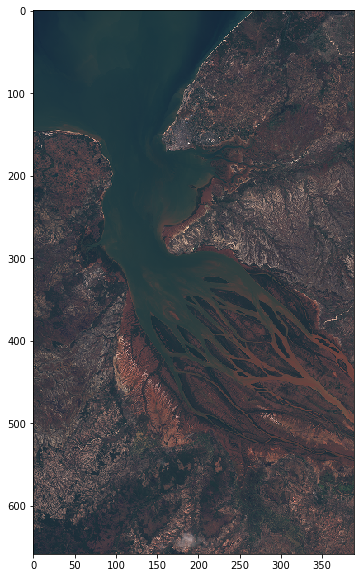

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(tar_img * 2.5, vmin=0, vmax=1);

## Building the request as a basic dictionary with helper functions

We can also just use SentinelHubRequest's helper functions (`input_data`, `body`, `output_response`, `output`, `bounds`) to construct just the body of a request and issue the request in some other way.

### Build the request

In [13]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"],
                units: "REFLECTANCE"
            }],
            output: {
                bands: 3,
                sampleType: "FLOAT32"
            }
        };
    }

    function evaluatePixel(sample) {
        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
"""

request_body = SentinelHubRequest.body(
    evalscript=evalscript,
    request_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L1C,
            time_interval=('2017-06-01T07:12:03', '2017-06-15T07:12:04'),
            mosaicking_order='leastCC'
        )
    ],
    request_output=SentinelHubRequest.output(
        size=selector.size,
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
    ),
    request_bounds=SentinelHubRequest.bounds(selector.bbox)
)

In [14]:
download_request = DownloadRequest(
    request_type='POST',
    url="https://services.sentinel-hub.com/api/v1/process",
    post_values=request_body,
    data_type=MimeType.TIFF,
    headers={'content-type': 'application/json'},
    use_session=True
)

In [15]:
client = SentinelHubDownloadClient()

### Execute the request

In [16]:
img = client.download(download_request)

### Visualize the downloaded image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


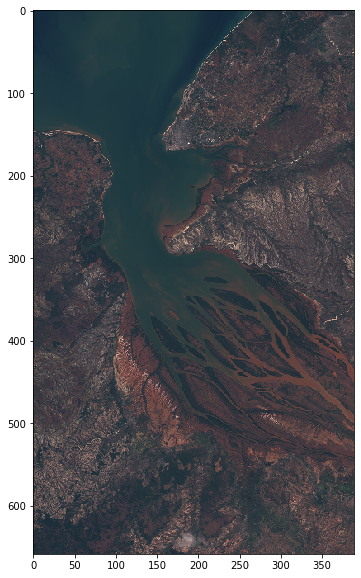

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(img, vmin=0, vmax=1);

## Building the request as a raw dictionary

We can also construct a raw dictionary as defined in the [API Reference](https://docs.sentinel-hub.com/api/latest/reference/), without any helper functions, so we have full control over building the request body.

In [18]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"],
                units: "REFLECTANCE"
            }],
            output: {
                bands: 3,
                sampleType: "FLOAT32"
            }
        };
    }

    function evaluatePixel(sample) {
        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
"""

request_body = {
    "input": {
        "bounds": {
            "properties": {
                "crs": selector.bbox.crs.opengis_string
            },
            "bbox": list(selector.bbox)
        },
        "data": [
            {
                "type": "S2L1C",
                "dataFilter": {
                    "timeRange": {"from": '2017-06-01T07:12:03Z', "to": '2017-06-15T07:12:04Z'},
                    "mosaickingOrder": "leastCC",
                }
            }
        ]
    },
    "output": {
        "width": selector.size[0],
        "height": selector.size[1],
        "responses": [
            {
                "identifier": "default",
                "format": {
                    'type': MimeType.TIFF.get_string()
                }
            }
        ]
    },
    "evalscript": evalscript
}

In [19]:
download_request = DownloadRequest(
    request_type='POST',
    url="https://services.sentinel-hub.com/api/v1/process",
    post_values=request_body,
    data_type=MimeType.TIFF,
    headers={'content-type': 'application/json'},
    use_session=True
)

In [20]:
client = SentinelHubDownloadClient()

### Execute the request

In [23]:
img = client.download(download_request)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


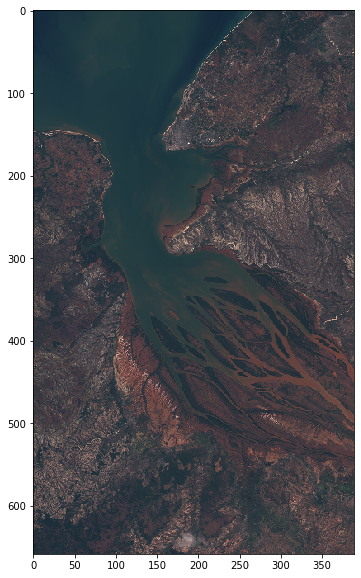

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(img, vmin=0, vmax=1);